# NENR DZ5 - Neuronske mreže

## Opis resursa

### Paket minikeras

Napisali smo po python file za neka osnovna ponašanja neuronskih mreža.

- Datoteka *callbacks.py* sadržava prototip klasu **Callback** koja služi za izradu callback funkcija koje će se pokretati u nekom trenutku treniranja. Trenutno su podržane aktivacije tih funkcija na početku treninga, epohe i iteracije, kao i na kraju treninga, epohe i iteracije.
- Datoteka *layers.py* sadržava prototip klasu **Layer** koja služi za izradu klasa slojeva neuronske mreže, kao i za izradu prototip klase **Activation** koja pak služi za izradu klasifikacijskih funkcija koje se tretiraju kao slojevi bez parametara koje možemo trenirati.
  - Od slojeva su trenutno dostupni:
    - Input - služi kao ulazni sloj koji kasnije prenosi dimenziju ulaza na sljedeće slojeve i nema aktivaciju.
    - Dense - potpuno povezani sloj uz pomake - po defaultu ima $n(m + 1)$ trenirabilnih parametara.
    - Droput - WIP 
  - Od aktivacijskih funkcija trenutno su dostupne:
    - Linear - linearna aktivacijska funkcija ($f(x) = x$)
    - Sigmoid - sigmoid ($f(x) = \frac{1}{1 + e^{-x}}$)
    - ReLU - rectified linear unit ($f(x) = max(0, x)$)
- Datoteka *losses.py* sadržava prototip klasu **Loss** koja služi za izradu funkcija gubitaka.
  - Od funkcija gubitaka trenutno su dostupne:
    - SquareError ($f(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2$)
    - MeanSquareError ($f(y, \hat{y}) = \frac{1}{2n}(y - \hat{y})^2$)
    - AbsoluteError ($f(y, \hat{y}) = |y - \hat{y}|$)
- Datoteka *metrics.py* sadržava klasu **Metric** koja služi za pohranu enumeratora neke metrike mreže. Trenutno su formalno podržani gubitak i validacijski gubitak, a postoje planovi i za točnost i validacijsku točnost.
- Datoteka *model.py* sadržava klasu **Model** koja može akumulirati slojeve te koristiti forward propagation i backpropagation, trenirati mrežu, te uz naučene mrežu stvarati predikcije. Također, moguć je i ispis modela po slojevima nalik na Kerasov model.summary().
- Datoteka *util.py* trnutno sadržava samo jednu metodu koja se koristi prilikom ispisa summaryja modela.

### Ostatak

Ostatak se može sumirati u 2 komponente: **gui** i **util**.

#### GUI

GUI služi za iscrtavanje korisničkog sučelja. Koristi se Tkinter.

#### Util

Služi primarnu za pretvorbu dataseta dobivenog pomoću GUI-ja u onaj koji ćemo koristiti u mreži.

## Učitavanje resursa

### Placeholderi

In [1]:
reference_points = 30

### Python alati

In [2]:
from itertools import product
from matplotlib import pyplot as plt
import numpy as np
import os

### GUI

In [3]:
from tkinter import Tk

from gui import GestureWindow

root = Tk()
root.resizable(False, False)
root.geometry("800x600")

app = GestureWindow(root, None, reference_points)

### Normalizacija podataka

In [4]:
from util import load_dataset, normalize_dataset

### Mreža

In [5]:
from minikeras.callbacks import ReduceLROnPlateau
from minikeras.layers import Input, Dense, Sigmoid
from minikeras.losses import MeanSquareError
from minikeras.model import Model

## Stvaranje dataseta

Prvo ćemo otvoriti GUI:

In [6]:
# Odkomentiraj ako treba zabilježiti podatke
# root.mainloop()

Zatim, automatski smo pozicionirani u tablici za zabilježavanje gesti. Automatski je odabarana gesta $\alpha$, no uz dropdown izbornik možemo odabrati zabilježavanje neke druge geste. Ispod toga nalazi se veliko platno na kojem možemo crtati gestu. Prilikom pokretanja programa, bilo koji postojeći dataset u *data/dataset.tsv* se automatski učitava u radnu memoriju programa.

- Ako nismo zadovoljni s gestom, možemo je obrisati pritiskom na tipku **Backspace**
- Ako smo zadovoljni s gestom, možemo je interno zapamtiti pritiskom na tipku **Return** (tj. **Enter**)

Ispod platna nalaze se gumbi za upravljanje datasetom.

- Ako nismo zadovoljni s učitanim datasetom (koji se po defaultu nalazi u *data/dataset.tsv*), možemo ga obrisati pritiskom na gumb **Zaboravi učitane podatke**
- Ako smo zadovoljni s zabilježenim datasetom, pritiskom na gumb **Pohrani u .tsv** on će se serijalizirati u *data/dataset.tsv* datoteci

Nakon što smo završili zapisivanje dataseta, možemo zatvoriti program.

### Dodatno

Zabilježene datasete, jedan za treniranje mreže a drugi za validaciju, pohranili smo u direktorij *data/20191221_dataset*, te ih nazvali *train.tsv* i *validation.tsv*. Ovo nije nužno, s obzirom da nam za trening treba samo skup za učenje, no zbog toga što će se ovdje koristiti callback **ReduceLROnPlateau**, koji najbolje radi kada pratimo validacijski gubitak, dodali smo i validacijski dataset.

## Normaliziranje dataseta

Sakupljene podatke potrebno je normalizirati. Prvo ćemu učitati naše snimljene datasetove funkcijom **load_dataset** iz **util.py**.

In [7]:
dataset_folder = "data/20191221_dataset"

train = load_dataset(os.path.join(dataset_folder, "train.tsv"))
validation = load_dataset(os.path.join(dataset_folder, "validation.tsv"))

Prikaz nekih podatka iz skupa za učenje može sa scatterom izgledati ovako:

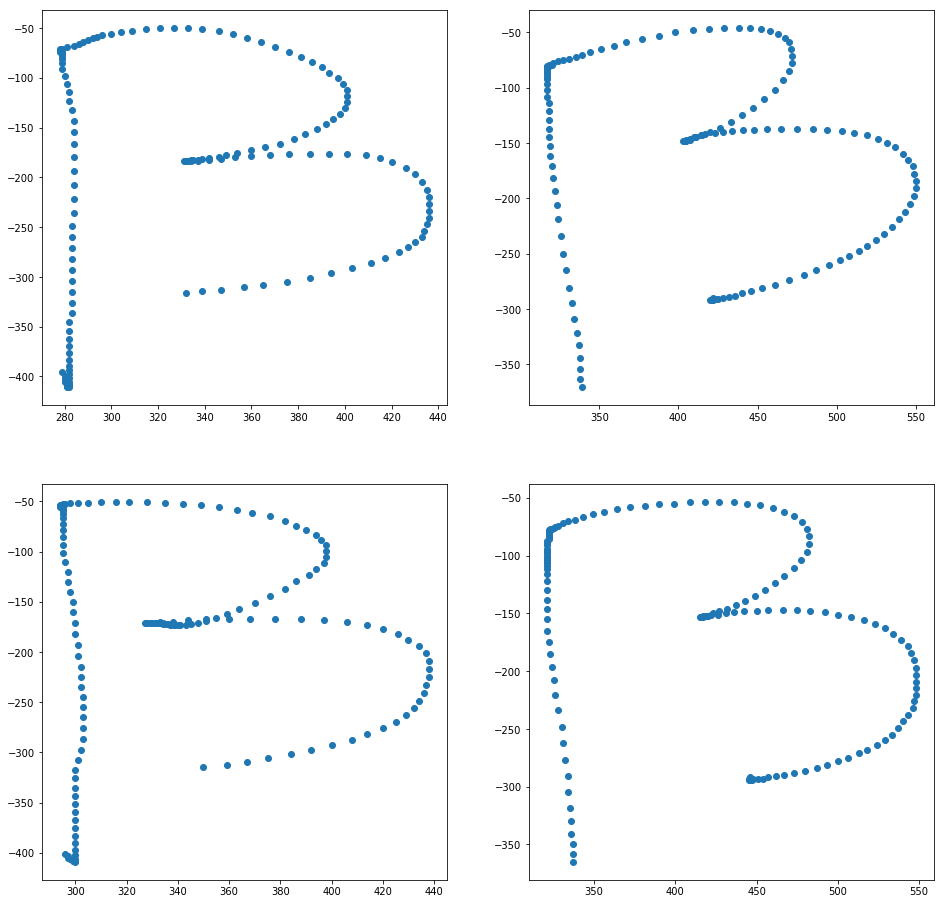

In [8]:
indices = np.arange(len(train))
np.random.shuffle(indices)

some_entries = np.array(train)[indices[:4]]

plt.figure(figsize=(16, 16))
for i, entry in enumerate(some_entries, 1):
    plt.subplot(2, 2, i)
    
    # Ovo radimo jer su nam učitane koordinate zrcaljene po y osi, 
    # a zrcaljenje natrag za neuronsku mrežu nije potrebno.
    entry_x = [[x[0], -x[1]] for x in entry[0]]
    
    x, y = list(zip(*entry_x))
    plt.scatter(x, y)

Ove podatke treba transformirati u raspon vrijednosti invarijantan na veličinu geste te poziciju u platnu. Ovo ćemo postići transformirajući naše datasetove funkcijom **normalize_dataset**.

In [9]:
train_n = normalize_dataset(train, reference_points, class_count=5)
validation_n = normalize_dataset(validation, reference_points, class_count=5)

Sad će iznad prikazani dataset izgledati malo drukčije. Uzeli smo $30$ referentnih točaka:

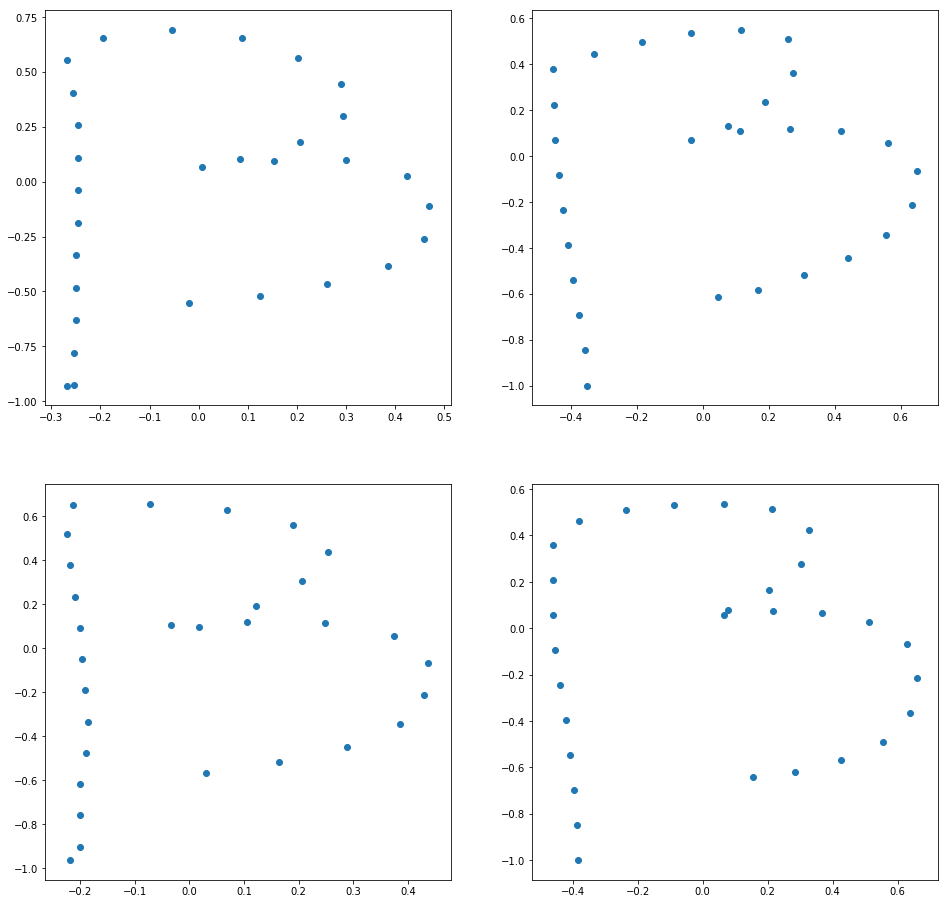

In [10]:
some_entries_2 = np.array(train_n)[indices[:4]]

plt.figure(figsize=(16, 16))
for i, entry in enumerate(some_entries_2, 1):
    plt.subplot(2, 2, i)
    
    # Ovo radimo jer su nam učitane koordinate zrcaljene po y osi, 
    # a zrcaljenje natrag za neuronsku mrežu nije potrebno.
    entry_x = [[x[0], -x[1]] for x in entry[0].reshape(-1, 2)]
    
    x, y = list(zip(*entry_x))
    plt.scatter(x, y)

## Metatreniranje mreže

Metatreniranje mreže obavit ćemo tako da ćemo, zbog prirode problema pretpostaviti da mreža nema više od 2 skrivena sloja. Dakle, metatreniranje možemo podijeliti na $2$ treninga: treniranje s $1$ skrivenim slojem i treniranje s $2$ skrivena sloja. Drugi hiper parametar koji ćemo podešavati je broj neurona u svakom skrivenom sloju. S obzirom da smo uzeli značajke u $60$ dimenzionalnom prostoru a imamo $5$ klasa, neke heuristike nam kažu da trebamo brojeve koji su u intervalu $[5, 60]$. Tako ćemo uzeti početni broj neurona od $5$, pa uz pomake od $5$ ići prema $60$ neurona po sloju.

U ovom slučaju će nam podešavanje stope učenja biti manje interesantan pojam - počet ćemo s $0.01$, kao umjereno velikoj vrijednosti te ćemo uz pomoć callbacka **ReduceLROnPlateau** dinamički smanjivati stopu učenja kad god nam validacijski gubitak prestane padati.

Finalno, evaluirat ćemo svaki model na $1000$ epoha. Iako je shuffle parametar dobro imati na True, ovog puta stavit ćemo ga na False jer nam je bitno da svaka konfiguracija trenira na istom redoslijedu podataka, tj. da eventualna nasumičnost proizlazi iz inicijalizacije težina.

In [11]:
# Blok ispod traje oko 1 sat xD
run_metatraining = False

In [12]:
if run_metatraining:
    layer_count_range = np.arange(1, 3)
    neuron_count_range = np.arange(5, 60 + 1, 5)
    starting_learning_rate = 0.01
    epochs = 1000
    
    ####    Rječnik koji mapira konfiguraciju na validacijski gubitak
    configuration_to_validation_loss = dict()
    
    ####    Stvaranje konfiguracija broja neurona
    final_configurations = list()
    
    for i in layer_count_range:
        base = [np.array([x]) for x in neuron_count_range]
        configurations = base

        for j in range(1, i):
            configurations = [np.array(x).flatten() for x in product(configurations, base)]

        final_configurations.append([tuple(np.ndarray.tolist(x)) for x in configurations])

    ####    Podešavanje datasetova
    x_train, y_train = [np.array(x) for x in list(zip(*train_n))]
    val_data = [np.array(x) for x in list(zip(*validation_n))]
    
    ####    Dodatni parametri modela
    loss = MeanSquareError()
    callbacks = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, cooldown=2, mode="min",verbose=0)
    
    for configurations in final_configurations:
        for configuration in configurations:
            layers = [Input(input_units=len(x_train[0]))]

            for neuron_count in configuration:
                layers.append(Dense(output_units=neuron_count, activation="sigmoid"))

            layers.append(Dense(output_units=len(y_train[0]), activation="sigmoid"))
            
            model = Model(layers)
            model.compile(loss=loss)
            
            history = model.fit(x=x_train, y=y_train,
                                validation_data = val_data,
                                batch_size=10,
                                epochs=epochs,
                                verbose=0,
                                callbacks=callbacks,
                                learning_rate=starting_learning_rate,
                                shuffle=False)

            print(f"Za konfiguraciju {list(configuration)} validacijski gubitak iznosi\t{history['val_loss'][-1]}")
else:
    print(f"Metatreniranje nije pokrenuto jer je parametar run_metatraining jednak {run_metatraining}.")
    
    # Podaci iz data/metatraining.log
    top_5 = [([45], 0.013607616135865839),
             ([40], 0.013802408465712086),
             ([50], 0.013955123038376658),
             ([55, 50], 0.014330453817441047),
             ([45, 55], 0.014510262407029365)]
                  
    print("Top 5 konfiguracija s validacijskim gubitcima:\n")
                  
    for configuration, conf_val_loss in top_5:
        print(f"{conf_val_loss:.06f}:\t\t{configuration}")
                  

Metatreniranje nije pokrenuto jer je parametar run_metatraining jednak False.
Top 5 konfiguracija s validacijskim gubitcima:

0.013608:		[45]
0.013802:		[40]
0.013955:		[50]
0.014330:		[55, 50]
0.014510:		[45, 55]


Iz dobivenih rezultata, vidljivo je da je najoptimalnija mreža s $1$ slojem $45$ skrivenih neurona. Međutim, vidimo da i slojevi s $40$ i $50$ nisu daleko. Neki minimum se najvjerojatnije nalazi između $40$ i $50$ neurona.

## Treniranje optimalne mreže

Sad kad znamo da će nam optimalna mreža biti oblika $60 x 45 x 5$, možemo krenuti s pravim treniranjem.

I ovog puta treniramo mrežu na $1000$ epoha, s tim da ćemo malo podesiti i parametre **ReduceLROnPlateau**. Također, izvesti ćemo učenje na 3 modela, a razlikovat će se po načinu učenja - 1. će učiti cijeli batch odjednom, 2. će batch size od $10$, dok će 3. učiti primjer po primjer. Početna stopa učenja neka ovog puta bude $0.1$.

Na kraju ćemo usporediti njihove validacijske gubitke.

In [13]:
models = [None, None, None]
histories = [None, None, None]

####    Za svaki slučaj još jednom
x_train_final, y_train_final = [np.array(x) for x in list(zip(*train_n))]
val_data_final = [np.array(x) for x in list(zip(*validation_n))]

batch_sizes = [len(x_train_final), 10, 1]

starting_learning_rate_final = 0.1
epochs_final = 1000
callbacks_final = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=20, cooldown=5, verbose=0)
loss_final = MeanSquareError()

layers_final = [Input(input_units=len(x_train_final[0])),
                Dense(output_units=45, activation="sigmoid"),
                Dense(output_units=len(y_train_final[0]), activation="sigmoid")]

for i in range(len(models)):
    models[i] = Model(layers_final)
    models[i].compile(loss=loss_final)
               
    histories[i] = models[i].fit(x=x_train_final, y=y_train_final,
                                validation_data = val_data_final,
                                batch_size=batch_sizes[i],
                                epochs=epochs_final,
                                verbose=0,
                                callbacks=callbacks_final,
                                learning_rate=starting_learning_rate_final,
                                shuffle=True)
               
    print(f"Validacijski gubitak {i + 1}. modela iznosi {histories[i]['val_loss'][-1][0]:.06f}")

Validacijski gubitak 1. modela iznosi 0.025326
Validacijski gubitak 2. modela iznosi 0.011081


F:\Backup\FER\NENR\DZ\DZ5\minikeras\layers.py:294: RuntimeWarning: overflow encountered in exp
  return np.reciprocal(1 + np.exp(-x))


Validacijski gubitak 3. modela iznosi 0.004195


Sad ovakav validacijski gubitak možemo i prikazati na grafovima

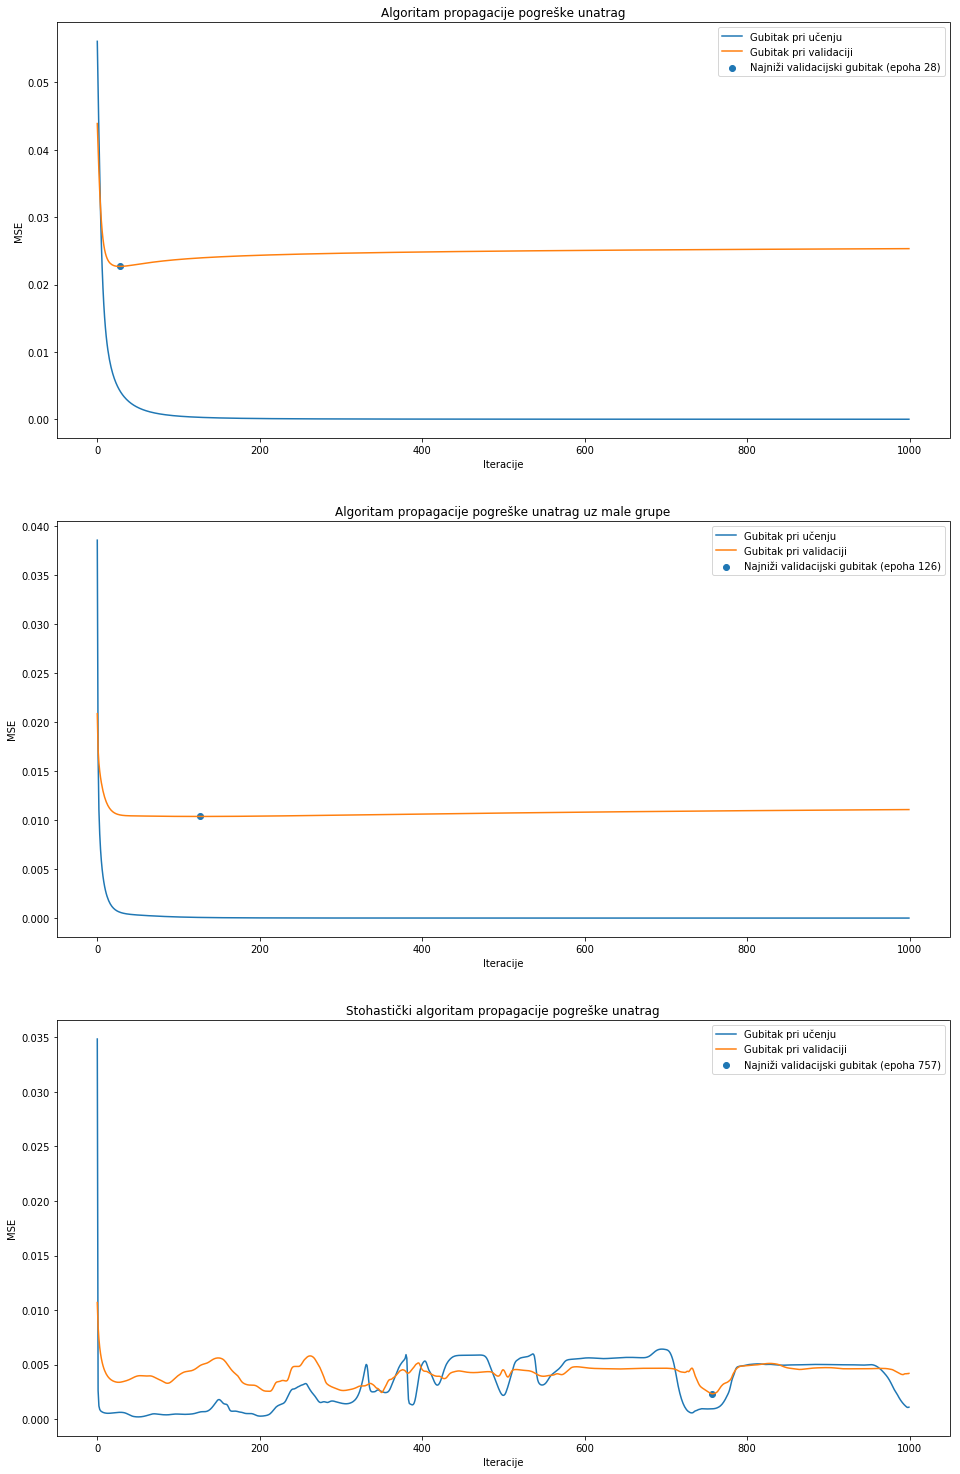

In [14]:
titles = ["Algoritam propagacije pogreške unatrag",
          "Algoritam propagacije pogreške unatrag uz male grupe",
          "Stohastički algoritam propagacije pogreške unatrag"]

loss_labels = ["Gubitak pri učenju",
               "Gubitak pri validaciji"]

plt.figure(figsize=(16, 26))

for i, model_history in enumerate(histories, 1):
    model_losses = [x[0] for x in model_history["loss"]]
    model_val_losses = [x[0] for x in model_history["val_loss"]]
    
    min_val_loss_index = np.argmin(model_val_losses)
    min_val_loss = model_val_losses[min_val_loss_index]
    
    x_axis = np.arange(0, len(model_losses))
    
    plt.subplot(3, 1, i)
    
    plt.title(titles[i - 1])
    plt.xlabel("Iteracije")
    plt.ylabel("MSE")
    plt.plot(x_axis, model_losses, label=loss_labels[0])
    plt.plot(x_axis, model_val_losses, label=loss_labels[1])
    
    plt.scatter(min_val_loss_index, min_val_loss, label=f"Najniži validacijski gubitak (epoha {min_val_loss_index})")
    
    plt.legend()

## Evaluacija rezultata

Kroz ova tri treninga smo uočili kako se ponaša mreža za različite obliku učenja. Možemo vidjeti da kad za jedno podešavanje težina uzmemo u obzir cijeli dataset imamo izrazito stabilno učenje koje brzo dolazi u optimum. Međutim, taj optimum još uvijek ima veći validacijski gubitak nego učenje s manjim grupama.

S druge strane, ako odjednom učimo na $10$ primjera, vidimo da se kasnije zaustavljamo na optimalnom gubitku, no sada je taj optimalni gubitak nekoliko puta niži od prethodnog primjera, što nas veseli.

Finalno, vidimo i što se događa kada učimo primjer po primjer. Na grafu se jasno vidi da je takvo treniranje nestabilno, tj. da validacijski gubitak izrazito varira.

Bez obzira na to, mi ćemo sve 3 mreže trenirati $100$ epoha. U idealnom slučaju, za ovo bi postojao callback koji bi snimio model na novom optimalnom validacijskom gubitku, no zbog toga što je vodstvu NENR-a važnije da labos napišemo u tjedan dana umjesto da ga napišemo kvalitetno, za serijalizaciju mreže, implementaciju **ModelCheckpoint** callbacka i debuggiranje jednostavno nema vremena.

### Naredbe kod klasifikatora

Klasifikator će, neovisno o broju poteza krenuti klasificirati uzorak nakon što pokazivač miša napusti platno. Ukoliko želimo prebrisati ono što je na platnu, za to će nam, slično kao i kod zabilježavanja gesti, poslužiti tipka **Delete** (ali ne i Backspace!). Brisanjem uzorka automatski resetiramo i klasifikaciju na nule.

In [19]:
models_eval = [None, None, None]

epochs_eval = [100, 100, 100]
batch_sizes_eval = [len(x_train_final), 10, 1]

starting_learning_rate_eval = 0.1
callbacks_eval = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=20, cooldown=5, verbose=0)
loss_eval = MeanSquareError()

layers_eval = [Input(input_units=len(x_train_final[0])),
               Dense(output_units=45, activation="sigmoid"),
               Dense(output_units=len(y_train_final[0]), activation="sigmoid")]

for i in range(len(models)):
    models_eval[i] = Model(layers_eval)
    models_eval[i].compile(loss=loss_eval)

    models_eval[i].fit(x=x_train_final, y=y_train_final,
                       validation_data = val_data_final,
                       batch_size=batch_sizes[i],
                       epochs=epochs_eval[i],
                       verbose=0,
                       callbacks=callbacks_eval,
                       learning_rate=starting_learning_rate_eval,
                       shuffle=True)
    
    print(f"Model {i + 1} istreniran.")

Model 1 istreniran.
Model 2 istreniran.
Model 3 istreniran.


Sad kad su modeli istrenirani, promjenom model_to_test na indeks mreže koju želimo koristiti možemo promijeniti klasifikator.

In [20]:
model_to_test = 1

app.switch_model(models_eval[model_to_test])
root.mainloop()

Također, ako želimo ponovno pokrenuti program, možemo pokrenuti funkciju ispod i pozvati je u nekom bloku:

In [21]:
def rerun(override_model: int = None):
    if override_model is None:
        override_model = model_to_test
        
    root = Tk()
    root.resizable(False, False)
    root.geometry("800x600")

    app = GestureWindow(root, None, reference_points)
    app.switch_model(models_eval[override_model])
    
    root.mainloop()

In [25]:
# rerun(1)